# Project 1: Digit Classification with KNN and Naive Bayes

In this project, you'll implement your own image recognition system for classifying digits. Read through the code and the instructions carefully and add your own code where indicated. Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but <b> please prepare your own write-up (with your own code). </b>

If you're interested, check out these links related to digit recognition:

Yann Lecun's MNIST benchmarks: http://yann.lecun.com/exdb/mnist/

Stanford Streetview research and data: http://ufldl.stanford.edu/housenumbers/

In [261]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Import a bunch of libraries.
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_mldata
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report

# Set the randomizer seed so results are the same each time.
np.random.seed(0)

Load the data. Notice that we are splitting the data into training, development, and test. We also have a small subset of the training data called mini_train_data and mini_train_labels that you should use in all the experiments below, unless otherwise noted.

In [262]:
# Load the digit data either from mldata.org, or once downloaded to data_home, from disk. The data is about 53MB so this cell
# should take a while the first time your run it.
mnist = fetch_mldata('MNIST original', data_home='~/datasets/mnist')
X, Y = mnist.data, mnist.target

# Rescale grayscale values to [0,1].
X = X / 255.0

# Shuffle the input: create a random permutation of the integers between 0 and the number of data points and apply this
# permutation to X and Y.
# NOTE: Each time you run this cell, you'll re-shuffle the data, resulting in a different ordering.
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]

print 'data shape: ', X.shape
print 'label shape:', Y.shape

# Set some variables to hold test, dev, and training data.
test_data, test_labels = X[61000:], Y[61000:]
dev_data, dev_labels = X[60000:61000], Y[60000:61000]
train_data, train_labels = X[:60000], Y[:60000]
mini_train_data, mini_train_labels = X[:1000], Y[:1000]

data shape:  (70000, 784)
label shape: (70000,)


(1) Create a 10x10 grid to visualize 10 examples of each digit. Python hints:

- plt.rc() for setting the colormap, for example to black and white
- plt.subplot() for creating subplots
- plt.imshow() for rendering a matrix
- np.array.reshape() for reshaping a 1D feature vector into a 2D matrix (for rendering)

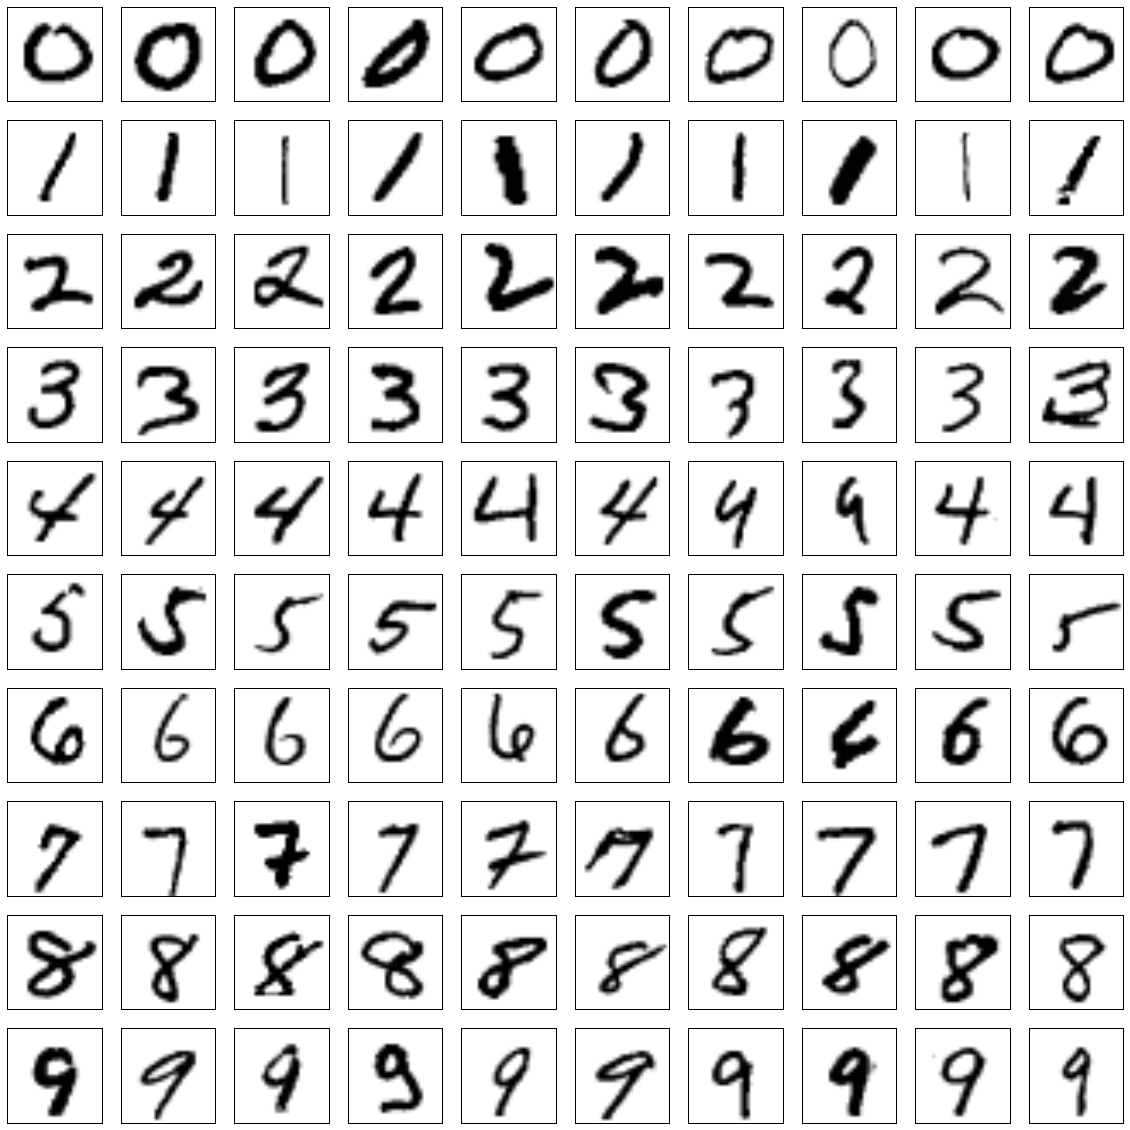

In [263]:
def P1(num_examples=10):

### STUDENT START ###

# Extract num_examples of each digit.
# Keep track of how many examples for each digit we've collected.
# Once we've collected num_examples of a digit, we no longer need
# to keep collecting more examples.
    counts = np.zeros(num_examples, int)
    examples = np.empty((10, num_examples), np.ndarray)
    for i in range(X.shape[0]):
        label = int(Y[i])
        # Add example if we haven't collected num_examples of this digit.
        if counts[label] < num_examples:
            examples[label][counts[label]] = X[i]
            counts[label] += 1

    # Plot examples.
    plt.figure(figsize=(20, 20))
    plt.rc('image', cmap='gray_r')
    for i in range(examples.shape[0]):
        for j in range(examples.shape[1]):
            ax = plt.subplot(10, num_examples, (i*10) + j + 1)
            plt.setp(ax, xticks=(), yticks=())
            # Reshape vector into 28x28 matrix and render matrix.
            plt.imshow(np.reshape(examples[i][j], (28, 28)))       

### STUDENT END ###

P1(10)

(2) Evaluate a K-Nearest-Neighbors model with k = [1,3,5,7,9] using the mini training set. Report accuracy on the dev set. For k=1, show precision, recall, and F1 for each label. Which is the most difficult digit?

- KNeighborsClassifier() for fitting and predicting
- classification_report() for producing precision, recall, F1 results

In [264]:
def P2(k_values):

### STUDENT START ###
    # Run K-Nearest-Neighbors and compute accuracy for each k in k_values.
    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k)
        # Run K-Nearest-Neighbors on training set.
        knn.fit(mini_train_data, mini_train_labels)
        # Compute accuracy of model on dev set.
        accuracy = knn.score(dev_data, dev_labels)
        print 'Accuracy for k={0}: {1}'.format(k, accuracy)
        # Print detailed report for k=1
        if k == 1:
            predictions = knn.predict(dev_data)
            print 'Classification results for k=1'
            print classification_report(dev_labels, predictions)
    
### STUDENT END ###

k_values = [1, 3, 5, 7, 9]
P2(k_values)

Accuracy for k=1: 0.888
Classification results for k=1
             precision    recall  f1-score   support

        0.0       0.91      0.98      0.94        99
        1.0       0.89      1.00      0.94       105
        2.0       0.99      0.79      0.88       102
        3.0       0.77      0.87      0.82        86
        4.0       0.89      0.82      0.85       104
        5.0       0.93      0.84      0.88        91
        6.0       0.94      0.96      0.95        98
        7.0       0.89      0.92      0.90       113
        8.0       0.94      0.88      0.91        96
        9.0       0.78      0.82      0.80       106

avg / total       0.89      0.89      0.89      1000

Accuracy for k=3: 0.878
Accuracy for k=5: 0.869
Accuracy for k=7: 0.865
Accuracy for k=9: 0.863


ANSWER:  
For k=1, the digit 9 has the lowest f1-score and is the hardest to predict.


(3) Using k=1, report dev set accuracy for the training set sizes below. Also, measure the amount of time needed for prediction with each training size.

- time.time() gives a wall clock value you can use for timing operations

In [276]:
def P3(train_sizes, accuracies):

### STUDENT START ###
    for train_size in train_sizes:
        # Use k=1 in K-Nearest-Neighbors computation.
        knn = KNeighborsClassifier(n_neighbors=1)
        # Run K-Nearest-Neighbors on training set.
        knn.fit(train_data[:train_size], train_labels[:train_size])
        # Get start time.
        start_time = time.time()
        # Compute accuracy of model on dev set.
        accuracy = knn.score(dev_data, dev_labels)
        # Get end time.
        end_time = time.time()
        # Compute amount of time needed for prediction.
        prediction_time = end_time - start_time

        # Print accuracy and training times.
        print 'For training set size {0}, Accuracy: {1:.2f}, Prediction time: {2:.4f}s'.format(
            train_size, accuracy, prediction_time)
        
        # Add accuracy to the accuracies list.
        accuracies.append(accuracy)

### STUDENT END ###

train_sizes = [100, 200, 400, 800, 1600, 3200, 6400, 12800, 25000]
accuracies = []
P3(train_sizes, accuracies)

For training set size 100, Accuracy: 0.72, Prediction time: 0.1199s
For training set size 200, Accuracy: 0.79, Prediction time: 0.2254s
For training set size 400, Accuracy: 0.84, Prediction time: 0.4897s
For training set size 800, Accuracy: 0.88, Prediction time: 1.0529s
For training set size 1600, Accuracy: 0.90, Prediction time: 2.0244s
For training set size 3200, Accuracy: 0.93, Prediction time: 3.9641s
For training set size 6400, Accuracy: 0.94, Prediction time: 7.8668s
For training set size 12800, Accuracy: 0.96, Prediction time: 15.7637s
For training set size 25000, Accuracy: 0.97, Prediction time: 29.7891s


(4) Fit a regression model that predicts accuracy from training size. What does it predict for n=60000? What's wrong with using regression here? Can you apply a transformation that makes the predictions more reasonable?

- Remember that the sklearn fit() functions take an input matrix X and output vector Y. So each input example in X is a vector, even if it contains only a single value.

Predicted accuracy for training size=60000: [ 1.24307226]
Predicted accuracy using logit transformation for training size=60000: [ 0.99881796]


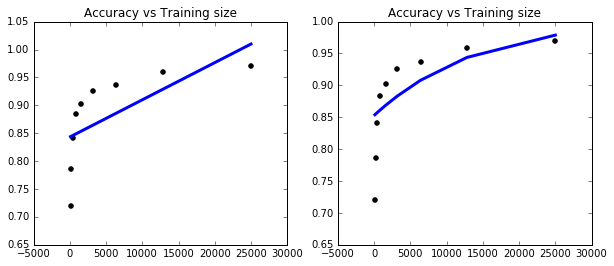

In [266]:
def P4():

### STUDENT START ###
    regr = LinearRegression()
    # Reshape train_sizes list to a matrix since sklearn fit() functions expect a matrix X.
    train_sizes_matrix = np.reshape(train_sizes, (len(train_sizes), 1))
    # Fit a linear regression model.
    regr.fit(train_sizes_matrix, accuracies)
    
    # Plot regression model against scatterplot.
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.title('Accuracy vs Training size')
    plt.scatter(train_sizes, accuracies, color='black')
    plt.plot(train_sizes, regr.predict(train_sizes_matrix), color='blue', linewidth=3)
    
    # Compute prediction for n=60000 using linear regression model.
    prediction = regr.predict([[60000]])
    print 'Predicted accuracy for training size=60000: {0}'.format(prediction)
    
    # Transform data using logit.
    # Compute logit of Y (accuracies).
    accuracies_logit = [np.log(i / (1 - i)) for i in accuracies]
    regr.fit(train_sizes_matrix, accuracies_logit)
    plt.subplot(1, 2, 2)
    plt.title('Accuracy vs Training size')
    plt.scatter(train_sizes, accuracies, color='black')
    # Convert regression output back to accuracy.
    predictions_logit = regr.predict(train_sizes_matrix)
    predictions = [(np.exp(i) / (1 + np.exp(i))) for i in predictions_logit]
    plt.plot(train_sizes, predictions, color='blue', linewidth=3)

    # Compute prediction for n=60000 using linear regression model.
    prediction_logit = regr.predict([[60000]])
    # Convert prediction back to accuracy.
    prediction = np.exp(prediction_logit) / (1 + np.exp(prediction_logit))
    print 'Predicted accuracy using logit transformation for training size=60000: {0}'.format(prediction)

### STUDENT END ###

P4()

ANSWER:  
With a linear regression, it predicts an accuracy of 1.23 for training size=60000. This is clearly an invalid prediction since the accuracy cannot be greater than 1. A logit transformation of the accuracy would make this prediction more reasonable by restricting the value to be between 0 and 1.

(5) Fit a 1-NN and output a confusion matrix for the dev data. Use the confusion matrix to identify the most confused pair of digits, and display a few example mistakes.

- confusion_matrix() produces a confusion matrix

In [267]:
def P5():

### STUDENT START ###
    # Use k=1 in K-Nearest-Neighbors computation.
    knn = KNeighborsClassifier(n_neighbors=1)
    # Run K-Nearest-Neighbors on training set.
    knn.fit(mini_train_data, mini_train_labels)
    predictions = knn.predict(dev_data)
    cm = confusion_matrix(dev_labels, predictions)
    print 'Confusion matrix:'
    print cm
    
    print 'The most confused pair of digits is (4, 9).\n'
    
    # Find a few example mistakes.
    print 'A few example mistakes:'
    mistakes = 0
    for i in range(len(dev_labels)):
        # Only collect 5 examples.
        if mistakes == 5:
            break;
        # Find examples where the prediction doesn't match the actual label and the confused pairs are (4, 9).
        if predictions[i] != dev_labels[i] and (predictions[i] == 4 or predictions[i] == 9) and (dev_labels[i] == 4 or dev_labels[i] == 9):
            print 'For training example {0}, predicted label is {1} while actual label is {2}'.format(
                i, predictions[i], dev_labels[i])
            mistakes += 1
    
### STUDENT END ###

P5()

Confusion matrix:
[[ 97   0   0   0   0   0   2   0   0   0]
 [  0 105   0   0   0   0   0   0   0   0]
 [  4   4  81   4   0   0   0   4   3   2]
 [  1   0   0  75   0   3   0   3   1   3]
 [  0   2   0   0  85   0   3   0   0  14]
 [  2   0   0   9   0  76   0   1   1   2]
 [  1   1   1   0   1   0  94   0   0   0]
 [  1   4   0   1   1   0   0 104   0   2]
 [  0   2   0   5   0   2   1   0  84   2]
 [  1   0   0   3   9   1   0   5   0  87]]
The most confused pair of digits is (4, 9).

A few example mistakes:
For training example 24, predicted label is 4.0 while actual label is 9.0
For training example 82, predicted label is 4.0 while actual label is 9.0
For training example 110, predicted label is 4.0 while actual label is 9.0
For training example 173, predicted label is 9.0 while actual label is 4.0
For training example 178, predicted label is 9.0 while actual label is 4.0


(6) A common image processing technique is to smooth an image by blurring. The idea is that the value of a particular pixel is estimated as the weighted combination of the original value and the values around it. Typically, the blurring is Gaussian -- that is, the weight of a pixel's influence is determined by a Gaussian function over the distance to the relevant pixel.

Implement a simplified Gaussian blur by just using the 8 neighboring pixels: the smoothed value of a pixel is a weighted combination of the original value and the 8 neighboring values. Try applying your blur filter in 3 ways:
- preprocess the training data but not the dev data
- preprocess the dev data but not the training data
- preprocess both training and dev data

Note that there are Guassian blur filters available, for example in scipy.ndimage.filters. You're welcome to experiment with those, but you are likely to get the best results with the simplified version I described above.

In [268]:
def P6():
### STUDENT START ###
    blurred_train_data = Preprocess(mini_train_data)
    blurred_dev_data = Preprocess(dev_data)
    
    # Use k=1 in K-Nearest-Neighbors computation.
    knn = KNeighborsClassifier(n_neighbors=1)
    
    # Compute accuracy with preprocessed training data but not dev data.
    knn.fit(blurred_train_data, mini_train_labels)
    accuracy = knn.score(dev_data, dev_labels)
    print 'Accuracy when preprocessing only training data: {0:.4f}\n'.format(accuracy)
    
    # Compute accuracy with preprocessed dev data but not training data.
    knn.fit(mini_train_data, mini_train_labels)
    accuracy = knn.score(blurred_dev_data, dev_labels)
    print 'Accuracy when preprocessing only dev data: {0:.4f}\n'.format(accuracy)
    
    # Compute accuracy with proprocessed training and dev data.
    knn.fit(blurred_train_data, mini_train_labels)
    accuracy = knn.score(blurred_dev_data, dev_labels)
    print 'Accuracy when preprocessing both training and dev data: {0:.4f}\n'.format(accuracy)

def Preprocess(data):
    blurred_data = np.empty(data.shape)
    # Compute new blurred image for each example.
    for example in range(data.shape[0]):
        # Reformat each example as a 28 x 28 matrix.
        formatted_example = np.reshape(data[example], (28, 28))
        blurred_example = np.empty(formatted_example.shape)
        # Loop through each value in pixel map.
        for i in range(blurred_example.shape[0]):
            for j in range(blurred_example.shape[1]):
                # Loop through each pixel in neighboring 8 and compute weighted average.
                value, weight_sum = 0.0, 0.0
                for k in range(i-1, i+2):
                    for l in range(j-1, j+2):
                        # For edges, use the closest available pixel.
                        row = np.minimum(27, np.maximum(0, k))
                        col = np.minimum(27, np.maximum(0, l))
                        # Compute the distance of the neighboring pixel.
                        dist_sq = (k-i)*(k-i) + (l-j)*(l-j)
                        # Let sigma = 1. Compute weight using the Gaussian function.
                        weight = np.exp(-dist_sq/2) / (2*np.pi)
                        value += formatted_example[row][col] * weight;
                        weight_sum += weight;
                # Compute the weighted average and save the new pixel value.
                blurred_example[i][j] = np.round((value / weight_sum), 8)
        # Transform pixel matrix back into a 1d array.
        blurred_data[example] = np.reshape(blurred_example, (1, 784))
    return blurred_data

### STUDENT END ###

P6()

Accuracy when preprocessing only training data: 0.9070

Accuracy when preprocessing only dev data: 0.8760

Accuracy when preprocessing both training and dev data: 0.9020



ANSWER:  
Blurring only the training data and both the training and dev data produce fairly similar accuracies. This is likely because blurring gives a higher deviation to prevent overfitting of the trained model which helps with being able to generalize more easily to the dev data. However, only blurring the dev data performs significantly worse because we're not helping with the overfitting.

(7) Fit a Naive Bayes classifier and report accuracy on the dev data. Remember that Naive Bayes estimates P(feature|label). While sklearn can handle real-valued features, let's start by mapping the pixel values to either 0 or 1. You can do this as a preprocessing step, or with the binarize argument. With binary-valued features, you can use BernoulliNB. Next try mapping the pixel values to 0, 1, or 2, representing white, grey, or black. This mapping requires MultinomialNB. Does the multi-class version improve the results? Why or why not?

In [269]:
def P7():

### STUDENT START ###
    # Preprocess training and dev data into binary values.
    binarized_train_data = BinarizeData(mini_train_data)
    binarized_dev_data = BinarizeData(dev_data)
    # Run Bernoulli classifier.
    bnb = BernoulliNB()
    bnb.fit(binarized_train_data, mini_train_labels)
    accuracy = bnb.score(binarized_dev_data, dev_labels)
    print 'Accuracy of BernoulliNB: {0:.4f}\n'.format(accuracy)
    
    # Preprocess training and dev data into multinomial values.
    multinomial_train_data = ConvertToMultinomial(mini_train_data)
    multinomial_dev_data = ConvertToMultinomial(dev_data)
    # Run Multinomial classifier.
    mnb = MultinomialNB()
    mnb.fit(multinomial_train_data, mini_train_labels)
    accuracy = mnb.score(multinomial_dev_data, dev_labels)
    print 'Accuracy of MultinomialNB: {0:.4f}'.format(accuracy)

# Helper function to convert a data array into binary features.
def BinarizeData(data, threshold=0.5):
    # Initialize a new feature array with the same shape as the original data.
    binarized_data = np.zeros(data.shape)

    # Apply a threshold to each feature.
    for feature in range(data.shape[1]):
        binarized_data[:,feature] = data[:,feature] > threshold
    return binarized_data

# Helper function to convert a data arry into multinomial features.
def ConvertToMultinomial(data):
    # Initialize a new feature array with the same shape as the original data.
    multinomial_data = np.zeros(data.shape)
    
    # Apply white, grey, black thresholds to each feature.
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            if data[i][j] < 0.33:
                multinomial_data[i][j] = 0
            elif data[i][j] < 0.66:
                multinomial_data[i][j] = 1
            else:
                multinomial_data[i][j] = 2
    return multinomial_data
    
### STUDENT END ###

P7()

Accuracy of BernoulliNB: 0.8150

Accuracy of MultinomialNB: 0.8020


ANSWER:  
The multi-class version does not appear to improve the accuracy. This is likely because multinomial models are typically used for frequency counts such as word count whereas this problem is more suitable for using features as binary values such as black and white. It could also be overfitting the model cause it to not generalize as well to the dev data.

(8) Use GridSearchCV to perform a search over values of alpha (the Laplace smoothing parameter) in a Bernoulli NB model. What is the best value for alpha? What is the accuracy when alpha=0? Is this what you'd expect?

- Note that GridSearchCV partitions the training data so the results will be a bit different than if you used the dev data for evaluation.

In [270]:
def P8(alphas):

### STUDENT START ###
    # Preprocess training and dev data into binary values.
    binarized_data = BinarizeData(mini_train_data)
    # Use GridSearchCV to search over values of alpha.
    nb = GridSearchCV(BernoulliNB(), alphas)
    nb.fit(binarized_data, mini_train_labels)
    return nb

### STUDENT END ###

alphas = {'alpha': [0.0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
nb = P8(alphas)

In [271]:
print nb.best_params_

# Calculate accuracy when alpha=0
bnb = BernoulliNB(alpha=0.0, binarize=0.5)
bnb.fit(mini_train_data, mini_train_labels)
accuracy = bnb.score(dev_data, dev_labels)
print 'Accuracy when alpha=0: {0:.4f}'.format(accuracy)

{'alpha': 0.01}
Accuracy when alpha=0: 0.0990


ANSWER:  
The best value for alpha using the mini_train_set is 0.01. The accuracy when alpha=0 is 0.099. This extremely low accuracy is expected because an alpha of 0 is equivalent to no smoothing.

(9) Try training a model using GaussianNB, which is intended for real-valued features, and evaluate on the dev data. You'll notice that it doesn't work so well. Try to diagnose the problem. You should be able to find a simple fix that returns the accuracy to around the same rate as BernoulliNB. Explain your solution.

Hint: examine the parameters estimated by the fit() method, theta\_ and sigma\_.

Accuracy of GaussianNB model without adjustments: 0.6210
Accuracy of GaussianNB model with sigma adjustment: 0.8000


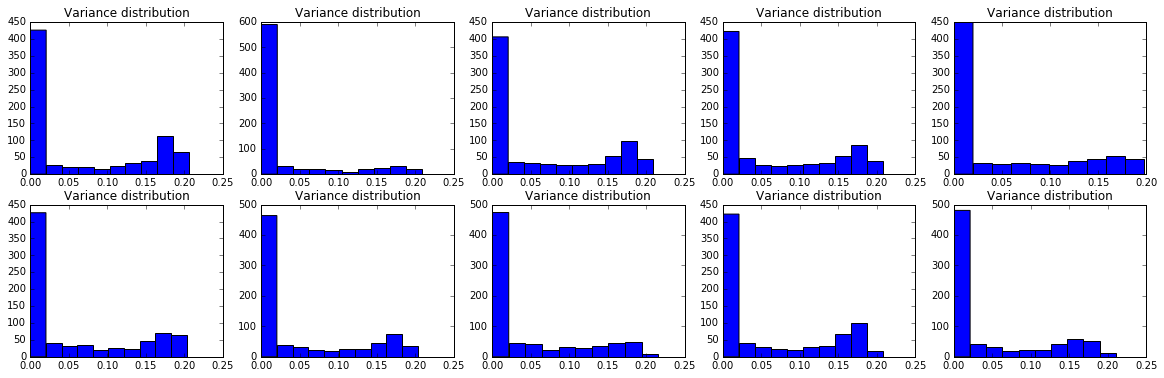

In [272]:
def P9():

### STUDENT END ###
    # Fit a standard GaussainNB model without adjustments.
    gnb = GaussianNB()
    gnb.fit(mini_train_data, mini_train_labels)
    accuracy = gnb.score(dev_data, dev_labels)
    print 'Accuracy of GaussianNB model without adjustments: {0:.4f}'.format(accuracy)
    
    # Look at distribution of variance.
    plt.figure(figsize=(20, 6))
    for i,sigma in enumerate(gnb.sigma_):
        plt.subplot(2, 5, i+1)
        plt.title('Variance distribution')
        plt.hist(sigma)
    
    # Set variance to have a uniform distribution.
    gnb.sigma_= np.full(gnb.sigma_.shape, 2, dtype=np.int)
    accuracy = gnb.score(dev_data, dev_labels)
    print 'Accuracy of GaussianNB model with sigma adjustment: {0:.4f}'.format(accuracy)
    return gnb

### STUDENT END ###

gnb = P9()


ANSWER:  
The main issue with Gaussian model on our data is that the variance computed is not normally distributed. Additionally, the sigmas computed are all extremely small meaning any slight difference in pixel value will cause the probability of the class to be zero. I have fixed the issue by applying a uniform and larger value variance which removes much of the noise caused by the small non-uniform original variance.

(10) Because Naive Bayes is a generative model, we can use the trained model to generate digits. Train a BernoulliNB model and then generate a 10x20 grid with 20 examples of each digit. Because you're using a Bernoulli model, each pixel output will be either 0 or 1. How do the generated digits compare to the training digits?

- You can use np.random.rand() to generate random numbers from a uniform distribution
- The estimated probability of each pixel is stored in feature\_log\_prob\_. You'll need to use np.exp() to convert a log probability back to a probability.

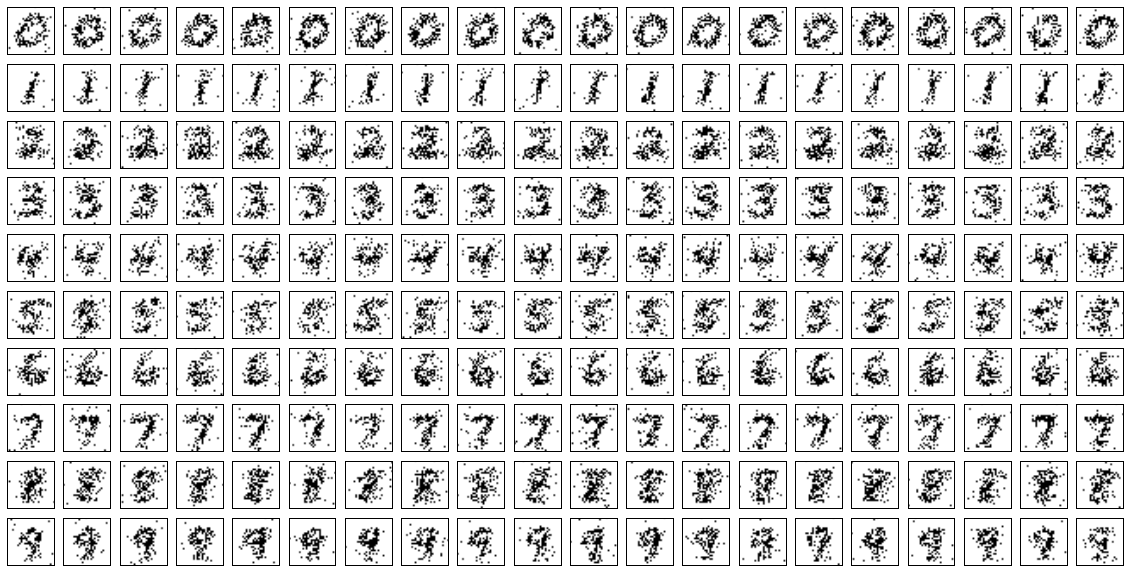

In [273]:
def P10(num_examples):

### STUDENT START ###
    # Train BernoulliNB model.
    bnb = BernoulliNB(binarize=0.5)
    bnb.fit(mini_train_data, mini_train_labels)
    
    # Generate examples.
    examples = np.empty((10, num_examples), np.ndarray)
    # Loop through each digit since we need to generate num_examples for each digit.
    for digit in range(10):
        # Generate num_examples for each digit.
        for i in range(num_examples):
            # For each feature value, generate a random number and compare to the feature prob.
            # This means that there will be feature prob that the feature will be "on" since there is an equal
            # prob of getting every number between 0 and 1 using the random number generator.
            examples[digit, i] = np.random.rand(1, 784) <= np.exp(bnb.feature_log_prob_[digit])
            
    # Plot examples.
    plt.figure(figsize=(20, 10))
    plt.rc('image', cmap='gray_r')
    for i in range(examples.shape[0]):
        for j in range(examples.shape[1]):
            ax = plt.subplot(10, num_examples, (i*20) + j + 1)
            plt.setp(ax, xticks=(), yticks=())
            # Reshape vector into 28x28 matrix and render matrix.
            plt.imshow(np.reshape(examples[i][j], (28, 28)))
    
    return examples

### STUDENT END ###

b = P10(20)

ANSWER:  
The generated digits seem to be much more uniform and similar to each other than the numbers in the training set. Additionally, the digits are much less defined and smooth than in the training set and instead consist of dots (looking like Pointillism). This is caused by using random numbers to determine whether pixels are on or off, meaning there is no guarantee that pixels next to each other will form continuous lines whereas real examples don't have this issue.

(11) Remember that a strongly calibrated classifier is rougly 90% accurate when the posterior probability of the predicted class is 0.9. A weakly calibrated classifier is more accurate when the posterior is 90% than when it is 80%. A poorly calibrated classifier has no positive correlation between posterior and accuracy.

Train a BernoulliNB model with a reasonable alpha value. For each posterior bucket (think of a bin in a histogram), you want to estimate the classifier's accuracy. So for each prediction, find the bucket the maximum posterior belongs to and update the "correct" and "total" counters.

How would you characterize the calibration for the Naive Bayes model?

In [274]:
def P11(buckets, correct, total):
    
### STUDENT START ###
    bnb = BernoulliNB(alpha=.01, binarize=0.5)
    bnb.fit(mini_train_data, mini_train_labels)
    predictions = bnb.predict(dev_data)
    # For each prediction, we want to take the maximum prob since that is the prob of the class
    # we choose for that example.
    pred_probs = np.max(bnb.predict_proba(dev_data), axis=1)

    # Loop through each prediction to check which maximum bucket it should fall in.
    for i in range(predictions.shape[0]):
        label = int(dev_labels[i])
        pred_label = int(predictions[i])
        pred_prob = pred_probs[i]
        # Check the special case first for whether the prediction should fall in the first bucket.
        if pred_prob <= buckets[0]:
            if pred_label == label:
                correct[0] += 1
            total[0] += 1
        # Otherwise, check which of the other buckets is the maximum bucket it should fall in.
        else:
            for j in range(1, len(buckets)):
                if pred_prob <= buckets[j] and pred_prob > buckets[j-1]:
                    if pred_label == label:
                        correct[j] += 1
                    total[j] += 1
                    break;
                
### STUDENT END ###

buckets = [0.5, 0.9, 0.999, 0.99999, 0.9999999, 0.999999999, 0.99999999999, 0.9999999999999, 1.0]
correct = [0 for i in buckets]
total = [0 for i in buckets]

P11(buckets, correct, total)

for i in range(len(buckets)):
    accuracy = 0.00
    if (total[i] > 0): accuracy = float(correct[i]) / total[i]
    print 'p(pred) <= %.13f    total = %3d    accuracy = %.3f' %(buckets[i], total[i], accuracy)

p(pred) <= 0.5000000000000    total =   0    accuracy = 0.000
p(pred) <= 0.9000000000000    total =  30    accuracy = 0.200
p(pred) <= 0.9990000000000    total =  86    accuracy = 0.465
p(pred) <= 0.9999900000000    total =  85    accuracy = 0.612
p(pred) <= 0.9999999000000    total =  58    accuracy = 0.690
p(pred) <= 0.9999999990000    total =  61    accuracy = 0.754
p(pred) <= 0.9999999999900    total =  73    accuracy = 0.877
p(pred) <= 0.9999999999999    total =  75    accuracy = 0.840
p(pred) <= 1.0000000000000    total = 532    accuracy = 0.953


ANSWER:  
The Naive Bayes model is weakly correlated because accuracy increases as the posterior probability increases. However, it is not strong correlated because posterior probability does not match up with accuracy.

(12) EXTRA CREDIT

Try designing extra features to see if you can improve the performance of Naive Bayes on the dev set. Here are a few ideas to get you started:
- Try summing the pixel values in each row and each column.
- Try counting the number of enclosed regions; 8 usually has 2 enclosed regions, 9 usually has 1, and 7 usually has 0.

Make sure you comment your code well!

In [275]:
def P12():
    # First calculate accuracy without additional features.
    bnb = BernoulliNB(alpha=.01, binarize=0.5)
    bnb.fit(mini_train_data, mini_train_labels)
    accuracy = bnb.score(dev_data, dev_labels)
    print 'Accuracy of BernoulliNB without additional features: {0:.4f}\n'.format(accuracy)
    
    # Add average of pixels for each row and column as additional features.
    mini_train_data_extra = AddNewSumPixelsFeatures(mini_train_data)
    dev_data_extra = AddNewSumPixelsFeatures(dev_data)
    # Train a Bernoulli NB model on mini training set with additional features.
    bnb = BernoulliNB(alpha=.01, binarize=0.5)
    bnb.fit(mini_train_data_extra, mini_train_labels)
    accuracy = bnb.score(dev_data_extra, dev_labels)
    print 'Accuracy of BernoulliNB with additional features: {0:.4f}\n'.format(accuracy)

### STUDENT START ###

def AddNewSumPixelsFeatures(data):
    # Create new variable to hold new data with extra features.
    # We add (2*28) extra spaces for the new features since there are 28 rows and 28 columns.
    extended_features_data = np.empty((data.shape[0], data.shape[1] + (2*28)))
    for i, example in enumerate(data):
        formatted_example = np.reshape(example, (28, 28))
        # Compute average pixel values for each row and column
        avg_rows = np.average(formatted_example, axis=1)
        avg_columns = np.average(formatted_example, axis=0)
        extended_features_data[i] = np.concatenate((example, avg_rows, avg_columns))
    return extended_features_data

### STUDENT END ###

P12()

Accuracy of BernoulliNB without additional features: 0.8180

Accuracy of BernoulliNB with additional features: 0.8250

